# Goodreads books data analysis

This notebook performs some exploratory analysis on the [Goodreads books dataset](https://www.kaggle.com/jealousleopard/goodreadsbooks) found on Kaggle.

This dataset is small enough that we could use Pandas, but for learning purposes I'll be using Spark.

## Set up and load data

In [1]:
import os

import findspark
findspark.init()

from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, FloatType, StringType, StructField, StructType
from pyspark_dist_explore import hist

import helpers as H

%matplotlib inline

spark = SparkSession.builder.appName("ExploreGoodreads").getOrCreate()

In [2]:
load_dotenv()

GOODREADS_BOOKS_PATH = os.getenv("GOODREADS_BOOKS_PATH")

In [3]:
book_schema = StructType([
    StructField("bookID", StringType(), True),
    StructField("title", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("isbn", StringType(), True),
    StructField("isbn13", StringType(), True),
    StructField("language_code", StringType(), True),
    StructField("num_pages", IntegerType(), True),    
    StructField("ratings_count", IntegerType(), True),    
    StructField("text_reviews_count", IntegerType(), True),
    StructField("publication_date", StringType(), True),
    StructField("publicater", StringType(), True),            
])
goodreads_df = spark.read.schema(book_schema).option("header", "true").csv(GOODREADS_BOOKS_PATH)

# Add a column that stores publication date as a datetime object
goodreads_df = goodreads_df.withColumn(
    "publication_date_ts", 
    F.to_timestamp(goodreads_df.publication_date, "M/d/yyyy"),
)

## Inspect table

In [4]:
goodreads_df.limit(5).toPandas().head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publicater,publication_date_ts
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,2006-09-16
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2004-09-01
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,2003-11-01
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,2004-05-01
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,2004-09-13


## BookID

In [5]:
H.get_basic_counts(goodreads_df, goodreads_df.bookID)
H.check_nulls(goodreads_df, goodreads_df.bookID, goodreads_df.title)
H.check_lengths(goodreads_df, goodreads_df.bookID)

+-------------+----------------------+
|count(bookID)|count(DISTINCT bookID)|
+-------------+----------------------+
|        11127|                 11127|
+-------------+----------------------+

+-----------------+
|Has Null (bookID)|
+-----------------+
|                0|
+-----------------+

+------+--------------+
|bookID|length(bookID)|
+------+--------------+
|     1|             1|
|     9|             1|
|     4|             1|
|     5|             1|
|     2|             1|
|     8|             1|
|    10|             2|
|    12|             2|
|    13|             2|
|    14|             2|
+------+--------------+
only showing top 10 rows

+------+--------------+
|bookID|length(bookID)|
+------+--------------+
| 10000|             5|
| 10034|             5|
| 10002|             5|
| 10004|             5|
| 10006|             5|
| 10008|             5|
| 10009|             5|
| 10013|             5|
| 10023|             5|
| 10029|             5|
+------+--------------+
only 

## Title

In [6]:
H.get_basic_counts(goodreads_df, goodreads_df.title)
H.check_nulls(goodreads_df, goodreads_df.title, goodreads_df.bookID)
H.check_empty_strings(goodreads_df, goodreads_df.title)
H.check_lengths(goodreads_df, goodreads_df.title)

+------------+---------------------+
|count(title)|count(DISTINCT title)|
+------------+---------------------+
|       11127|                10352|
+------------+---------------------+

+----------------+
|Has Null (title)|
+----------------+
|               0|
+----------------+

+-----------------+
|Has Empty (title)|
+-----------------+
|                0|
+-----------------+

+------+-------------+
| title|length(title)|
+------+-------------+
|    V.|            2|
|    V.|            2|
|    V.|            2|
|   Tim|            3|
|   Dry|            3|
|   Moo|            3|
|戰廢品|            3|
|   Dry|            3|
|   Kim|            3|
|   Out|            3|
+------+-------------+
only showing top 10 rows

+--------------------+-------------+
|               title|length(title)|
+--------------------+-------------+
|Yours in Food  Jo...|          254|
|The covert war ag...|          210|
|Dr. Mary's Monkey...|          209|
|Christian Mythmak...|          202|
|My Story as 

## Authors

In [7]:
H.get_basic_counts(goodreads_df, goodreads_df.authors)
H.check_nulls(goodreads_df, goodreads_df.authors, goodreads_df.bookID)
H.check_empty_strings(goodreads_df, goodreads_df.authors)
H.check_lengths(goodreads_df, goodreads_df.authors)

+--------------+-----------------------+
|count(authors)|count(DISTINCT authors)|
+--------------+-----------------------+
|         11127|                   6643|
+--------------+-----------------------+

+------------------+
|Has Null (authors)|
+------------------+
|                 0|
+------------------+

+-------------------+
|Has Empty (authors)|
+-------------------+
|                  0|
+-------------------+

+-------+---------------+
|authors|length(authors)|
+-------+---------------+
|    Avi|              3|
|    Avi|              3|
|    Avi|              3|
|  Homer|              5|
|  CLAMP|              5|
|  CLAMP|              5|
|  CLAMP|              5|
|  Noire|              5|
|  CLAMP|              5|
|  CLAMP|              5|
+-------+---------------+
only showing top 10 rows

+--------------------+---------------+
|             authors|length(authors)|
+--------------------+---------------+
|Garrison Keillor/...|            750|
|Nicholas Dawidoff...|         

In [8]:
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.average_rating).alias("avg_average_rating"),
        F.min(goodreads_df.average_rating).alias("min_average_rating"),
        F.max(goodreads_df.average_rating).alias("max_average_rating"),
     )
     .sort(F.desc("total_title"))
     .show(5)
)
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.ratings_count).alias("avg_ratings_count"),        
        F.min(goodreads_df.ratings_count).alias("min_ratings_rating"),
        F.max(goodreads_df.ratings_count).alias("max_ratings_count"),    
     )
     .sort(F.desc("total_title"))
     .show(5)
)
(
    goodreads_df
    .groupBy(goodreads_df.authors)
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.text_reviews_count).alias("avg_reviews_count"),               
        F.min(goodreads_df.text_reviews_count).alias("min_reviews_count"),        
        F.max(goodreads_df.text_reviews_count).alias("max_reviews_count"),         
     )
     .sort(F.desc("total_title"))
     .show(5)
)

+----------------+-----------+------------------+------------------+------------------+
|         authors|total_title|avg_average_rating|min_average_rating|max_average_rating|
+----------------+-----------+------------------+------------------+------------------+
|  P.G. Wodehouse|         40| 4.147250026464462|              3.78|              4.48|
|    Stephen King|         40| 3.973499995470047|              3.32|              4.54|
|Rumiko Takahashi|         39|4.1866667209527435|              3.88|              4.36|
|Orson Scott Card|         35|3.7791428702218193|              3.33|              4.49|
| Agatha Christie|         33|3.9890909267194345|              3.66|              4.39|
+----------------+-----------+------------------+------------------+------------------+
only showing top 5 rows

+----------------+-----------+------------------+------------------+-----------------+
|         authors|total_title| avg_ratings_count|min_ratings_rating|max_ratings_count|
+--------

## Average Rating

+---------------------+------------------------------+
|count(average_rating)|count(DISTINCT average_rating)|
+---------------------+------------------------------+
|                11123|                           209|
+---------------------+------------------------------+

+-------------------------+
|Has Null (average_rating)|
+-------------------------+
|                        0|
+-------------------------+

+---------------------+-------------------+-------------------+-------------------+
|count(average_rating)|avg(average_rating)|min(average_rating)|max(average_rating)|
+---------------------+-------------------+-------------------+-------------------+
|                11123| 3.9340753506533823|                0.0|                5.0|
+---------------------+-------------------+-------------------+-------------------+



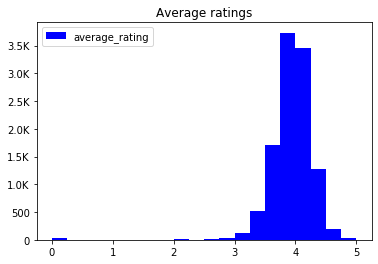

In [9]:
H.get_basic_counts(goodreads_df, goodreads_df.average_rating)
H.check_nulls(goodreads_df, goodreads_df.average_rating, goodreads_df.bookID)
H.basic_stats(goodreads_df, goodreads_df.average_rating)
H.plot_hist(goodreads_df.select(goodreads_df.average_rating), bins=20, title="Average ratings")

## Number of pages

+----------------+-------------------------+
|count(num_pages)|count(DISTINCT num_pages)|
+----------------+-------------------------+
|           11123|                      997|
+----------------+-------------------------+

+--------------------+
|Has Null (num_pages)|
+--------------------+
|                   0|
+--------------------+

+----------------+-----------------+--------------+--------------+
|count(num_pages)|   avg(num_pages)|min(num_pages)|max(num_pages)|
+----------------+-----------------+--------------+--------------+
|           11123|336.4055560550211|             0|          6576|
+----------------+-----------------+--------------+--------------+



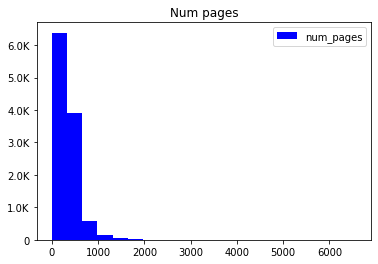

In [10]:
H.get_basic_counts(goodreads_df, goodreads_df.num_pages)
H.check_nulls(goodreads_df, goodreads_df.num_pages, goodreads_df.bookID)
H.basic_stats(goodreads_df, goodreads_df.num_pages)
H.plot_hist(goodreads_df.select(goodreads_df.num_pages), bins=20, title="Num pages")

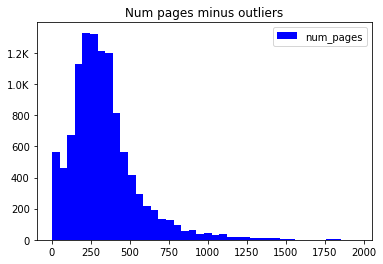

In [11]:
num_pages_df_no_outlier = goodreads_df.select(goodreads_df.num_pages).filter(goodreads_df.num_pages < 2000)
H.plot_hist(num_pages_df_no_outlier, bins=40, title="Num pages minus outliers")

## ISBN

In [12]:
H.get_basic_counts(goodreads_df, goodreads_df.isbn)
H.check_nulls(goodreads_df, goodreads_df.isbn, goodreads_df.bookID)
H.check_empty_strings(goodreads_df, goodreads_df.isbn)
H.check_lengths(goodreads_df, goodreads_df.isbn)

+-----------+--------------------+
|count(isbn)|count(DISTINCT isbn)|
+-----------+--------------------+
|      11127|               11126|
+-----------+--------------------+

+---------------+
|Has Null (isbn)|
+---------------+
|              0|
+---------------+

+----------------+
|Has Empty (isbn)|
+----------------+
|               0|
+----------------+

+----------+------------+
|      isbn|length(isbn)|
+----------+------------+
|      3.63|           4|
|      0.00|           4|
|      3.58|           4|
|      3.58|           4|
| 084386874|           9|
|0439785960|          10|
|0439554896|          10|
|0439358078|          10|
|043965548X|          10|
|0439682584|          10|
+----------+------------+
only showing top 10 rows

+----------+------------+
|      isbn|length(isbn)|
+----------+------------+
|0439785960|          10|
|0439358078|          10|
|0439554896|          10|
|043965548X|          10|
|0439682584|          10|
|0976540606|          10|
|0439827604| 

### Check ISBN lengths

Looks like there are some ISBNS with invalid values.

In [13]:
H.check_lengths(goodreads_df, goodreads_df.isbn)

+----------+------------+
|      isbn|length(isbn)|
+----------+------------+
|      3.63|           4|
|      0.00|           4|
|      3.58|           4|
|      3.58|           4|
| 084386874|           9|
|0439785960|          10|
|0439554896|          10|
|0439358078|          10|
|043965548X|          10|
|0439682584|          10|
+----------+------------+
only showing top 10 rows

+----------+------------+
|      isbn|length(isbn)|
+----------+------------+
|0439785960|          10|
|0439358078|          10|
|0439554896|          10|
|043965548X|          10|
|0439682584|          10|
|0976540606|          10|
|0439827604|          10|
|0517226952|          10|
|0345453743|          10|
|1400052920|          10|
+----------+------------+
only showing top 10 rows



## ISBN13

In [14]:
H.get_basic_counts(goodreads_df, goodreads_df.isbn13)
H.check_nulls(goodreads_df, goodreads_df.isbn13, goodreads_df.bookID)
H.check_empty_strings(goodreads_df, goodreads_df.isbn13)

+-------------+----------------------+
|count(isbn13)|count(DISTINCT isbn13)|
+-------------+----------------------+
|        11127|                 11127|
+-------------+----------------------+

+-----------------+
|Has Null (isbn13)|
+-----------------+
|                0|
+-----------------+

+------------------+
|Has Empty (isbn13)|
+------------------+
|                 0|
+------------------+



## Check ISBN13 lengths

Looks like there are a few ISBNs instead ISBN13s

In [15]:
H.check_lengths(goodreads_df, goodreads_df.isbn13)

+-------------+--------------+
|       isbn13|length(isbn13)|
+-------------+--------------+
|   156384155X|            10|
|   0851742718|            10|
|   0674842111|            10|
|   1593600119|            10|
|9780439785969|            13|
|9780439655484|            13|
|9780439358071|            13|
|9780439682589|            13|
|9780976540601|            13|
|9780439554893|            13|
+-------------+--------------+
only showing top 10 rows

+-------------+--------------+
|       isbn13|length(isbn13)|
+-------------+--------------+
|9780439785969|            13|
|9780439358071|            13|
|9780439554893|            13|
|9780439655484|            13|
|9780439682589|            13|
|9780976540601|            13|
|9780439827607|            13|
|9780517226957|            13|
|9780345453747|            13|
|9781400052929|            13|
+-------------+--------------+
only showing top 10 rows



## Language code

In [16]:
H.get_basic_counts(goodreads_df, goodreads_df.language_code)
H.check_nulls(goodreads_df, goodreads_df.language_code, goodreads_df.bookID)
H.check_empty_strings(goodreads_df, goodreads_df.language_code)

+--------------------+-----------------------------+
|count(language_code)|count(DISTINCT language_code)|
+--------------------+-----------------------------+
|               11127|                           31|
+--------------------+-----------------------------+

+------------------------+
|Has Null (language_code)|
+------------------------+
|                       0|
+------------------------+

+-------------------------+
|Has Empty (language_code)|
+-------------------------+
|                        0|
+-------------------------+



### Check unique language codes

Looks like some language codes are ISBNs.

In [17]:
(
    goodreads_df
    .select(goodreads_df.language_code)
    .distinct()
    .sort(goodreads_df.language_code.desc()).show(31)
)

+-------------+
|language_code|
+-------------+
|          zho|
|          wel|
|          tur|
|          swe|
|          srp|
|          spa|
|          rus|
|          por|
|          nor|
|           nl|
|          mul|
|          msa|
|          lat|
|          jpn|
|          ita|
|          grc|
|          glg|
|          gla|
|          ger|
|          fre|
|          enm|
|          eng|
|        en-US|
|        en-GB|
|        en-CA|
|          ara|
|          ale|
|9781593600112|
|9781563841552|
|9780851742717|
|9780674842113|
+-------------+



## Ratings count

+--------------------+-----------------------------+
|count(ratings_count)|count(DISTINCT ratings_count)|
+--------------------+-----------------------------+
|               11127|                         5294|
+--------------------+-----------------------------+

+------------------------+
|Has Null (ratings_count)|
+------------------------+
|                       0|
+------------------------+

+--------------------+------------------+------------------+------------------+
|count(ratings_count)|avg(ratings_count)|min(ratings_count)|max(ratings_count)|
+--------------------+------------------+------------------+------------------+
|               11127|17936.490159072528|                 0|           4597666|
+--------------------+------------------+------------------+------------------+



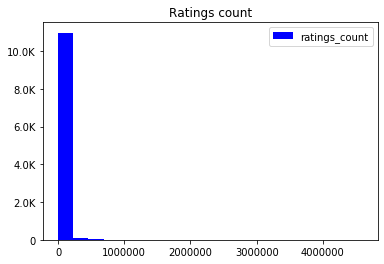

In [18]:
H.get_basic_counts(goodreads_df, goodreads_df.ratings_count)
H.check_nulls(goodreads_df, goodreads_df.ratings_count, goodreads_df.bookID)
H.basic_stats(goodreads_df, goodreads_df.ratings_count)
H.plot_hist(goodreads_df.select(goodreads_df.ratings_count), bins=20, title="Ratings count")

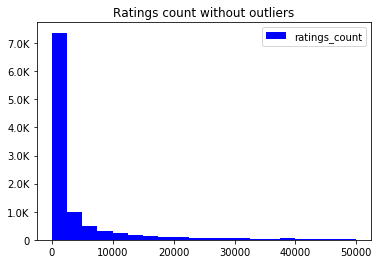

In [19]:
H.plot_hist(
    goodreads_df.select(goodreads_df.ratings_count).filter(goodreads_df.ratings_count < 50000), 
    bins=20, 
    title="Ratings count without outliers",
)


## Text reviews count

+-------------------------+----------------------------------+
|count(text_reviews_count)|count(DISTINCT text_reviews_count)|
+-------------------------+----------------------------------+
|                    11127|                              1822|
+-------------------------+----------------------------------+

+-----------------------------+
|Has Null (text_reviews_count)|
+-----------------------------+
|                            0|
+-----------------------------+

+-------------------------+-----------------------+-----------------------+-----------------------+
|count(text_reviews_count)|avg(text_reviews_count)|min(text_reviews_count)|max(text_reviews_count)|
+-------------------------+-----------------------+-----------------------+-----------------------+
|                    11127|      541.8644738024625|                      0|                  94265|
+-------------------------+-----------------------+-----------------------+-----------------------+



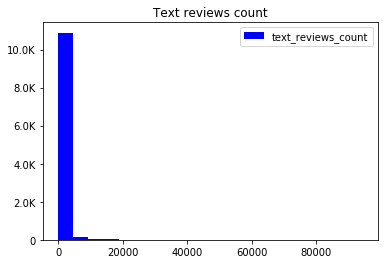

In [20]:
H.get_basic_counts(goodreads_df, goodreads_df.text_reviews_count)
H.check_nulls(goodreads_df, goodreads_df.text_reviews_count, goodreads_df.bookID)
H.basic_stats(goodreads_df, goodreads_df.text_reviews_count)
H.plot_hist(goodreads_df.select(goodreads_df.text_reviews_count), bins=20, title="Text reviews count")

## Publication date

The 1900-01-01 date sounds suspicious since in Python27 the date class had bug with dates earlier than 1900. Is it the case in Python38 as well?

In [21]:
H.get_basic_counts(goodreads_df, goodreads_df.publication_date_ts)
H.check_nulls(goodreads_df, goodreads_df.publication_date_ts, goodreads_df.bookID)
H.basic_stats(goodreads_df, goodreads_df.publication_date_ts)

+--------------------------+-----------------------------------+
|count(publication_date_ts)|count(DISTINCT publication_date_ts)|
+--------------------------+-----------------------------------+
|                     11121|                               3677|
+--------------------------+-----------------------------------+

+------------------------------+
|Has Null (publication_date_ts)|
+------------------------------+
|                             6|
+------------------------------+

+--------------------------+------------------------+------------------------+------------------------+
|count(publication_date_ts)|avg(publication_date_ts)|min(publication_date_ts)|max(publication_date_ts)|
+--------------------------+------------------------+------------------------+------------------------+
|                     11121|     9.675450212031292E8|     1900-01-01 00:00:00|     2020-03-31 00:00:00|
+--------------------------+------------------------+------------------------+--------------

### Group by publication date

Something seems off with the counts. I'm not sure why so few books published. Need to double check this.

In [22]:
(
    goodreads_df
    .groupBy(F.year(goodreads_df.publication_date_ts))
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.average_rating).alias("avg_average_rating"),
        F.min(goodreads_df.average_rating).alias("min_average_rating"),
        F.max(goodreads_df.average_rating).alias("max_average_rating"),
     )
     .sort(F.desc("min_average_rating"))
     .show(5)
)
(
    goodreads_df
    .groupBy(F.year(goodreads_df.publication_date_ts))
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.ratings_count).alias("avg_ratings_count"),        
        F.min(goodreads_df.ratings_count).alias("min_ratings_rating"),
        F.max(goodreads_df.ratings_count).alias("max_ratings_count"),    
     )
     .sort(F.desc("min_ratings_rating"))
     .show(5)
)
(
    goodreads_df
    .groupBy(F.year(goodreads_df.publication_date_ts))
    .agg(
        F.count(goodreads_df.title).alias("total_title"),
        F.avg(goodreads_df.text_reviews_count).alias("avg_reviews_count"),               
        F.min(goodreads_df.text_reviews_count).alias("min_reviews_count"),        
        F.max(goodreads_df.text_reviews_count).alias("max_reviews_count"),         
     )
     .sort(F.desc("min_reviews_count"))
     .show(5)
)

+-------------------------+-----------+------------------+------------------+------------------+
|year(publication_date_ts)|total_title|avg_average_rating|min_average_rating|max_average_rating|
+-------------------------+-----------+------------------+------------------+------------------+
|                     1922|          1|               5.0|               5.0|               5.0|
|                     1928|          1| 4.340000152587891|              4.34|              4.34|
|                     1919|          1| 4.320000171661377|              4.32|              4.32|
|                     1923|          1| 4.289999961853027|              4.29|              4.29|
|                     1943|          1| 4.210000038146973|              4.21|              4.21|
+-------------------------+-----------+------------------+------------------+------------------+
only showing top 5 rows

+-------------------------+-----------+-----------------+------------------+-----------------+
|year(p

### Check distribution of publication year

Looks like this dataset has subset of the Goodreads data

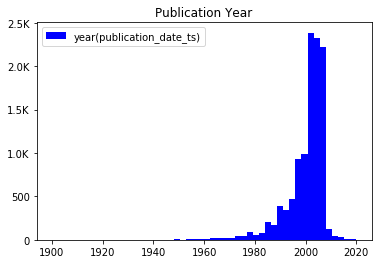

In [32]:
H.plot_hist(goodreads_df.select(F.year(goodreads_df.publication_date_ts)), bins=50, title="Publication Year")

## Publicator

The publicator can have duplicates

In [23]:
H.get_basic_counts(goodreads_df, goodreads_df.publicater)
H.check_nulls(goodreads_df, goodreads_df.publicater, goodreads_df.bookID)
H.check_lengths(goodreads_df, goodreads_df.publicater)

+-----------------+--------------------------+
|count(publicater)|count(DISTINCT publicater)|
+-----------------+--------------------------+
|            11127|                      2294|
+-----------------+--------------------------+

+---------------------+
|Has Null (publicater)|
+---------------------+
|                    0|
+---------------------+

+----------+------------------+
|publicater|length(publicater)|
+----------+------------------+
|        DK|                 2|
|      東立|                 2|
|      東立|                 2|
|        DK|                 2|
|      東立|                 2|
|      東立|                 2|
|      東立|                 2|
|      東立|                 2|
|      東立|                 2|
|      東立|                 2|
+----------+------------------+
only showing top 10 rows

+--------------------+------------------+
|          publicater|length(publicater)|
+--------------------+------------------+
|Crown Journeys/Cr...|                67|
|Harvard Universi

In [24]:
(
    goodreads_df
    .select(goodreads_df.publicater)
    .distinct()
    .filter(F.lower(goodreads_df.publicater).startswith("sch"))
    .sort(goodreads_df.publicater.asc()).show()
)

+--------------------+
|          publicater|
+--------------------+
|      Schirmer Mosel|
|      Schirmer/Mosel|
|            Schocken|
|      Schocken Books|
|  Schocken Books Inc|
|          Scholastic|
|    Scholastic  Inc.|
|Scholastic Audio ...|
|    Scholastic Books|
|      Scholastic Inc|
|     Scholastic Inc.|
|Scholastic Nonfic...|
|Scholastic Paperb...|
|    Scholastic Press|
|Scholastic Reference|
|School Specialty ...|
|Schwartz & Wade B...|
+--------------------+

